In [2]:
import tensorflow as tf
tf.keras.backend.clear_session(
    free_memory=True
)

In [3]:
tf.config.experimental.set_visible_devices([], 'GPU')

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
dataset_dir = 'TestData/train'
img_height, img_width = 150, 150

def load_dataset(dataset_dir, img_height, img_width):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    
    # Filter out unwanted files (e.g., .DS_Store)
    class_names = [class_name for class_name in class_names if not class_name.startswith('.')]
    
    num_classes = len(class_names)
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                try:
                    img = load_img(img_path, target_size=(img_height, img_width))
                    img_array = img_to_array(img)
                    images.append(img_array)
                    labels.append(label)  # Assign label based on class index
                except Exception as e:
                    print(f"Error loading {img_path}: {str(e)}")
    
    images = np.array(images)
    labels = np.array(labels)
    
    labels = to_categorical(labels, num_classes=num_classes)
    
    return images, labels, class_names, num_classes

images, labels, class_names, num_classes = load_dataset(dataset_dir, img_height, img_width)


Error loading TestData/train/S/.DS_Store: cannot identify image file <_io.BytesIO object at 0x321c68f40>


In [7]:
print(class_names)
print(num_classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
24


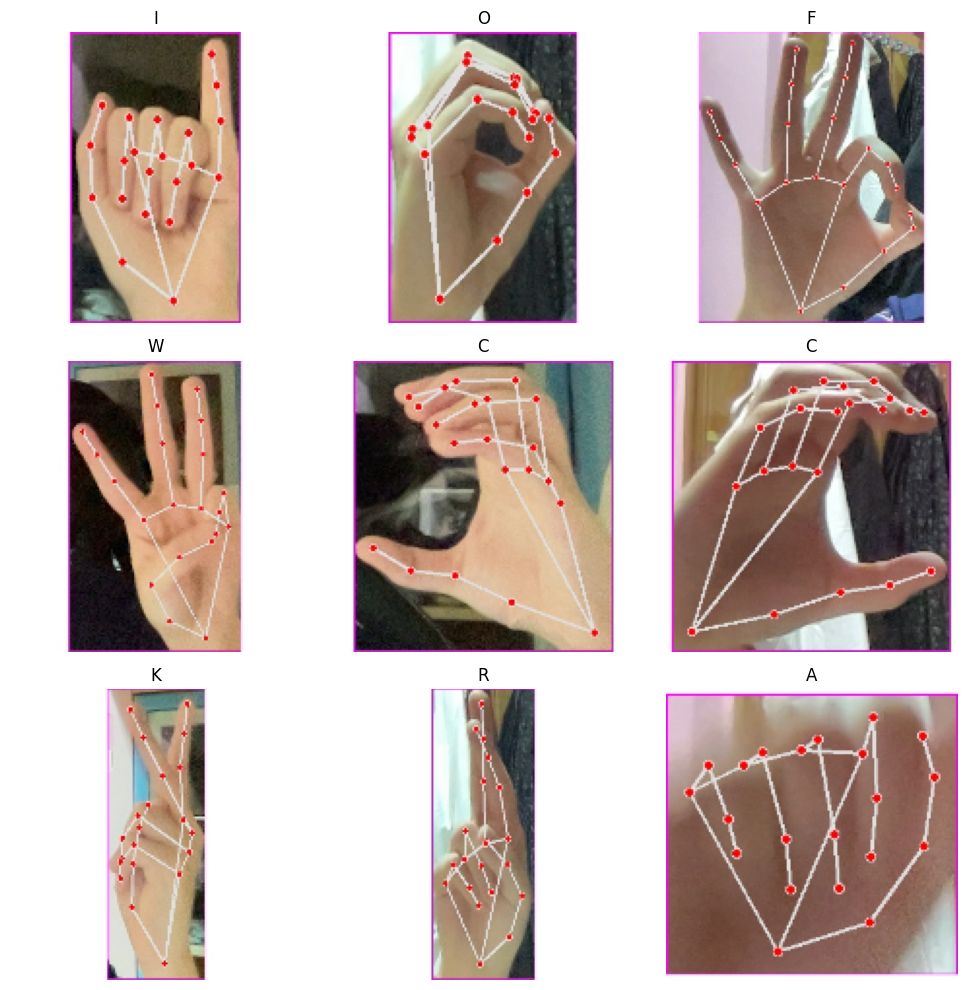

In [8]:
import random

def display_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    indices = random.sample(range(len(images)), 9)
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx].astype("uint8"))
        plt.title(class_names[np.argmax(labels[idx])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the images and their labels
display_images(images, labels, class_names)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

In [10]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer for 26 classes
])

model.compile(loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for multiple classes
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

/opt/anaconda3/envs/conda_tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,827,736 (26.05 MB)

 Trainable params: 6,825,752 (26.04 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [13]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset
)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 502ms/step - accuracy: 0.4374 - loss: 2.3377 - val_accuracy: 0.1793 - val_loss: 13.5732
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - accuracy: 0.9021 - loss: 0.3262 - val_accuracy: 0.3103 - val_loss: 4.9190
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 487ms/step - accuracy: 0.9598 - loss: 0.1719 - val_accuracy: 0.6207 - val_loss: 1.1460
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.9704 - loss: 0.0980 - val_accuracy: 0.9379 - val_loss: 0.2680
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - accuracy: 0.9820 - loss: 0.0838 - val_accuracy: 0.9793 - val_loss: 0.1003
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 500ms/step - accuracy: 0.9897 - loss: 0.0489 - val_accuracy: 0.9862 - val_loss: 0.1018
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - accuracy: 0.9914 - loss: 0.0425 - val_accuracy: 0.9724 - val_loss: 0.1091
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 536ms/step - accuracy: 0.9939 - loss: 0.0309 - val_acc

KeyboardInterrupt: 

In [14]:
loss, accuracy = model.evaluate(val_dataset)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9667 - loss: 0.1387
Validation Loss: 0.15220794081687927
Validation Accuracy: 0.9586206674575806


In [17]:
model.save('my_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


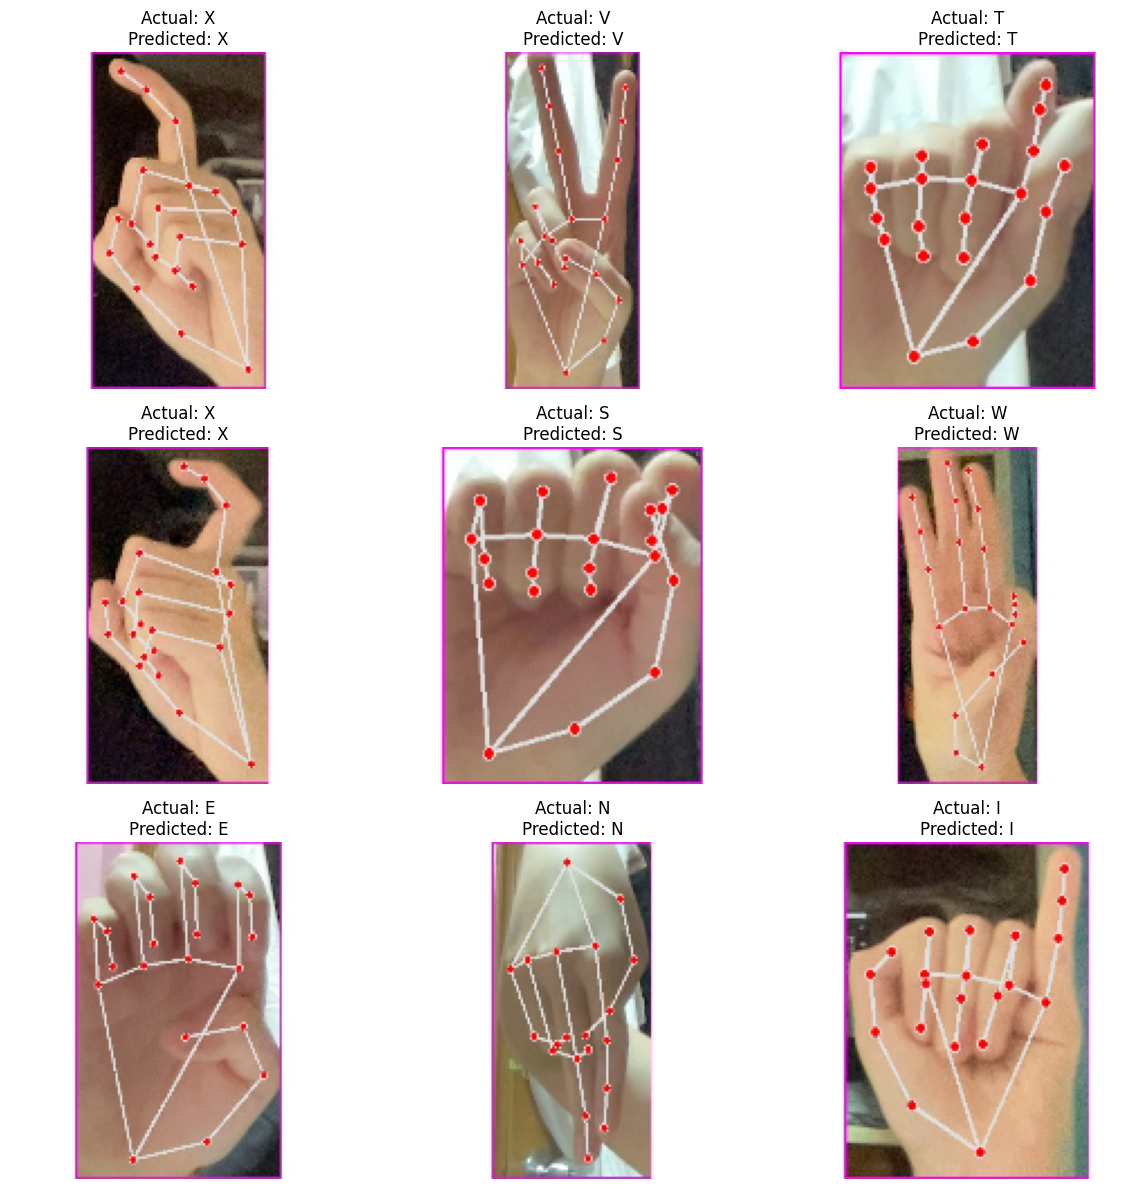

In [27]:
# Display Images with Actual and Predicted Labels
def display_images_with_predictions(images, actual_labels, class_names, model, num_images=9):
    plt.figure(figsize=(12, 12))
    indices = random.sample(range(len(images)), num_images)
    
    for i, idx in enumerate(indices):
        img = images[idx].astype("uint8")
        actual_label = class_names[np.argmax(actual_labels[idx])]
        
        # Prepare the image for prediction
        img_array = np.expand_dims(img, axis=0)
        predicted_label_idx = np.argmax(model.predict(img_array))
        predicted_label = class_names[predicted_label_idx]
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the images with actual and predicted labels
display_images_with_predictions(images, labels, class_names, model)

In [31]:
import cv2
from cvzone.HandTrackingModule import HandDetector
import numpy as np
import math
import time
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('trained_model-anna.keras')

# Function to get the class names
def get_class_names():
    class_names = "ABCDEFGHIKLMNOPQRSTUVWXY"
    return class_names

cap = cv2.VideoCapture(0)
detector = HandDetector(maxHands=1)
offset = 20
imgSize = 150
counter = 0

while True:
    success, img = cap.read()
    hands, img = detector.findHands(img)
    
    if hands:
        try:
            hand = hands[0]
            x, y, w, h = hand['bbox']
            imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255
            imgCrop = img[y - offset:y + h + offset, x - offset:x + w + offset]
            imgCropShape = imgCrop.shape
            aspectRatio = h / w
            
            if aspectRatio > 1:
                k = imgSize / h
                wCal = math.ceil(k * w)
                imgResize = cv2.resize(imgCrop, (wCal, imgSize))
                imgResizeShape = imgResize.shape
                wGap = math.ceil((imgSize - wCal) / 2)
                imgWhite[:, wGap:wCal + wGap] = imgResize
            else:
                k = imgSize / w
                hCal = math.ceil(k * h)
                imgResize = cv2.resize(imgCrop, (imgSize, hCal))
                imgResizeShape = imgResize.shape
                hGap = math.ceil((imgSize - hCal) / 2)
                imgWhite[hGap:hCal + hGap, :] = imgResize
            
            # Preprocess the image for prediction
            img_array = imgWhite.astype("float32")
            img_array = np.expand_dims(img_array, axis=0)
            
            # Make predictions
            predictions = model.predict(img_array, verbose=False)
            predicted_label_idx = np.argmax(predictions)
            class_names = get_class_names()  # Get class names
            predicted_label = class_names[predicted_label_idx]
            
            # Draw the bounding box and label on the hand
            cv2.rectangle(img, (x - offset, y - offset), (x + w + offset, y + h + offset), (255, 0, 255), 2)
            cv2.putText(img, predicted_label, (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
            
        except Exception as e:
            # print("Error:", e)
            continue
    
    cv2.imshow("Image", img)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break

cv2.destroyAllWindows()
cap.release()

I0000 00:00:1718814869.083889  281889 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718814869.112130  297967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718814869.123564  297961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/anaconda3/envs/conda_tf/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


KeyboardInterrupt: 

: 